In [ ]:
# Connecting Google Drive with Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [ ]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.4.3
Uninstalling matplotlib-3.4.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.4.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.4.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.4.3
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)


In [ ]:
# !pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install --force-reinstall albumentations==1.0.3
!pip install --upgrade git+https://github.com/albumentations-team/albumentations

  Using cached albumentations-1.0.3-py3-none-any.whl (98 kB)
  Using cached scikit_image-0.18.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (29.2 MB)
  Using cached opencv_python_headless-4.5.3.56-cp37-cp37m-manylinux2014_x86_64.whl (37.1 MB)
  Using cached numpy-1.21.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached PyYAML-5.4.1-cp37-cp37m-manylinux1_x86_64.whl (636 kB)
  Using cached scipy-1.7.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
  Using cached PyWavelets-1.1.1-cp37-cp37m-manylinux1_x86_64.whl (4.4 MB)
  Using cached Pillow-8.3.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (3.0 MB)
  Using cached matplotlib-3.4.3-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Using cached networkx-2.6.2-py3-none-any.whl (1.9 MB)
  Using cached imageio-2.9.0-py3-none-any.whl (3.3 MB)
  Using cached tifffile-2021.8.30-py3-none-any.whl (171 kB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached cycl

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-t9nzfi9u
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-t9nzfi9u


In [ ]:
DATA_DIR = 'drive/MyDrive/Machine_Learning/Project/Dataset/'

metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[metadata_df['split']=='train']
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)

(723, 80)

In [ ]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [ ]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [ ]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [ ]:
class LandCoverDataset(torch.utils.data.Dataset):

    """DeepGlobe Land Cover Classification Challenge Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

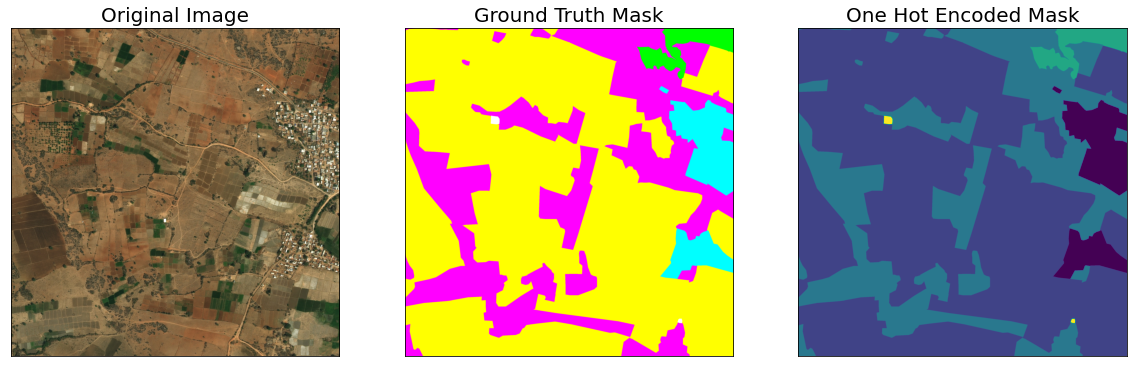

In [ ]:
dataset = LandCoverDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [ ]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=1024, width=1024, always_apply=True),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    train_transform = [
        album.CenterCrop(height=1024, width=1024, always_apply=True),
    ]
    return album.Compose(train_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

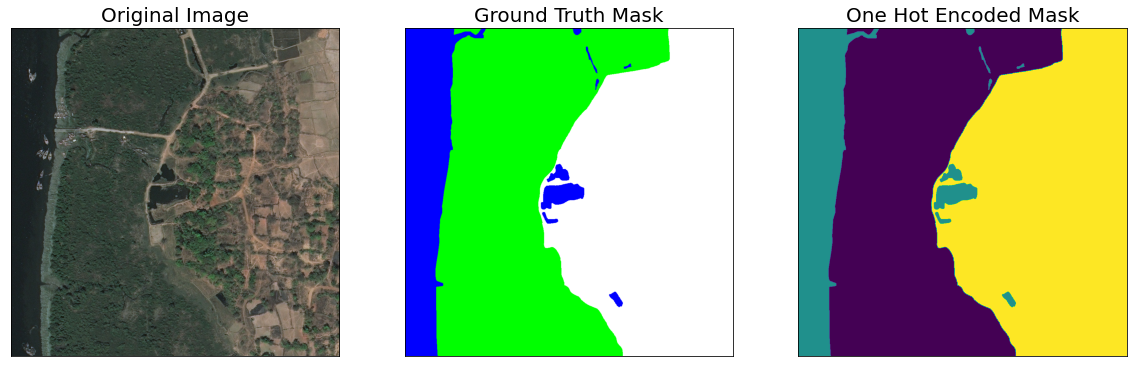

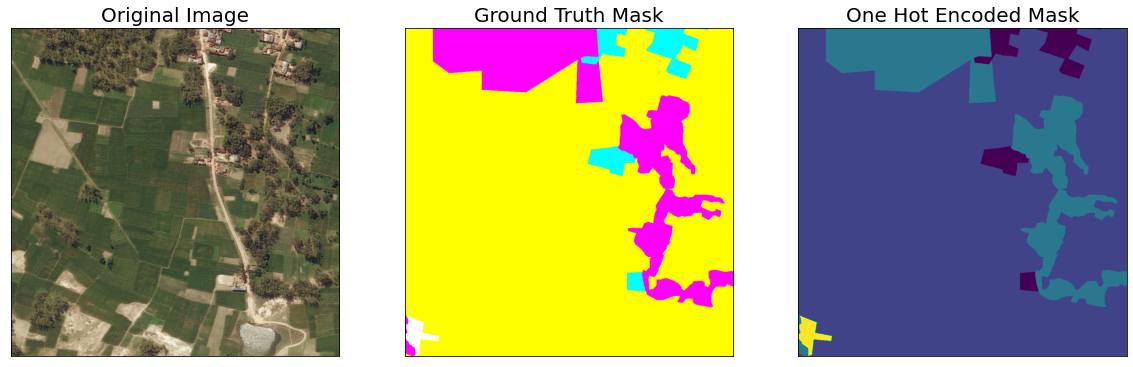

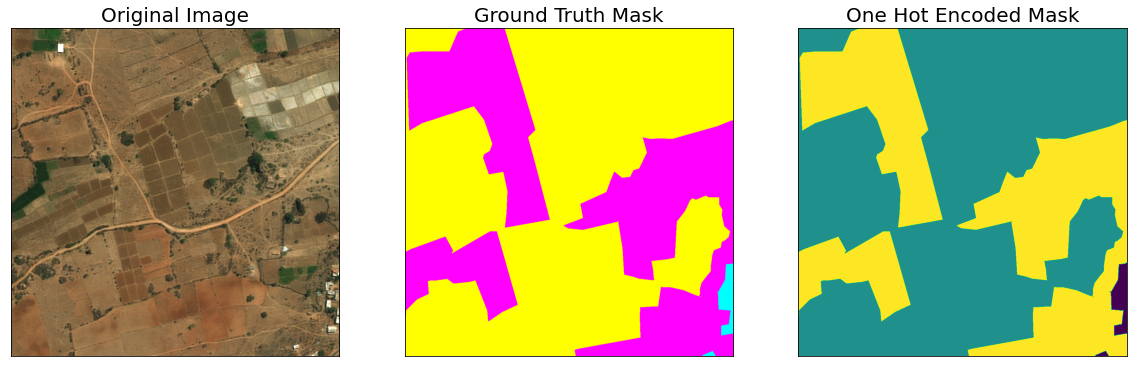

In [ ]:
augmented_dataset = LandCoverDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
# Get train and val dataset instances
train_dataset = LandCoverDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = LandCoverDataset(
    valid_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=4)

In [ ]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 5

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('drive/MyDrive/Machine_Learning/Project/best_model.pth'):
    model = torch.load('drive/MyDrive/Machine_Learning/Project/best_model.pth', map_location=DEVICE)
    print('Loaded pre-trained DeepLabV3+ model!')

Loaded pre-trained DeepLabV3+ model!


In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# %%time

# if TRAINING:

#     best_iou_score = 0.0
#     train_logs_list, valid_logs_list = [], []

#     for i in range(0, EPOCHS):

#         # Perform training & validation
#         print('\nEpoch: {}'.format(i))
#         train_logs = train_epoch.run(train_loader)
#         valid_logs = valid_epoch.run(valid_loader)
#         train_logs_list.append(train_logs)
#         valid_logs_list.append(valid_logs)

#         # Save model if a better val IoU score is obtained
#         if best_iou_score < valid_logs['iou_score']:
#             best_iou_score = valid_logs['iou_score']
#             torch.save(model, 'drive/MyDrive/Machine_Learning/Project/best_model.pth')
#             print('Model saved!')

In [ ]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('drive/MyDrive/Machine_Learning/Project/best_model.pth'):
    best_model = torch.load('drive/MyDrive/Machine_Learning/Project/best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from a previous commit.')

Loaded DeepLabV3+ model from a previous commit.


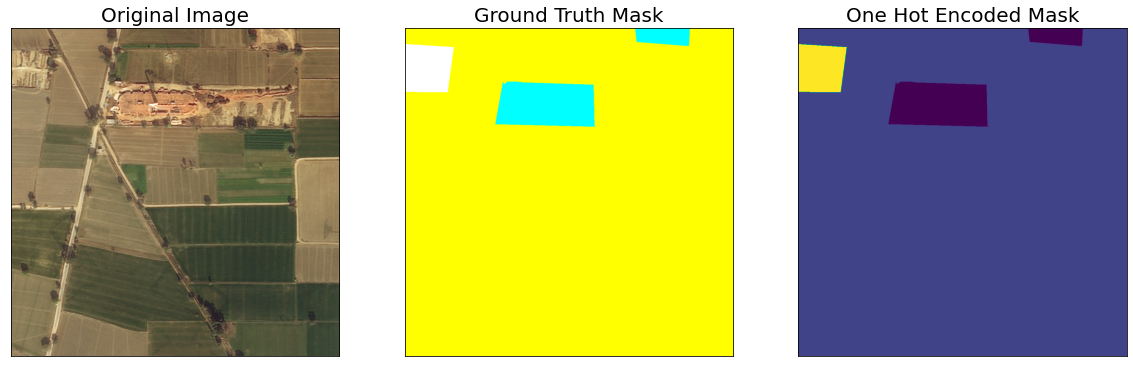

In [ ]:
# create test dataloader to be used with DeepLabV3+ model (with preprocessing operation: to_tensor(...))
test_dataset = LandCoverDataset(
    train_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = LandCoverDataset(
    train_df,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [ ]:
sample_preds_folder = 'drive/MyDrive/Machine_Learning/Project/sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
# best_model = model

(7, 1024, 1024)
Precision: 0.14285714285714238, Recall: 4.058558464049907, F1: 0.2759993805610195


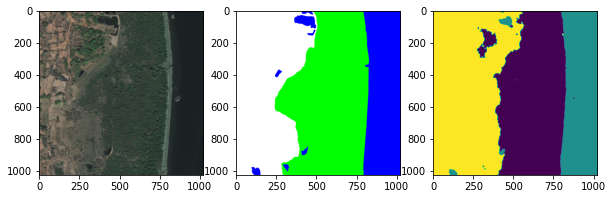

(7, 1024, 1024)
Precision: 0.14285714285714088, Recall: 0.9848308563231484, F1: 0.24951956562128005


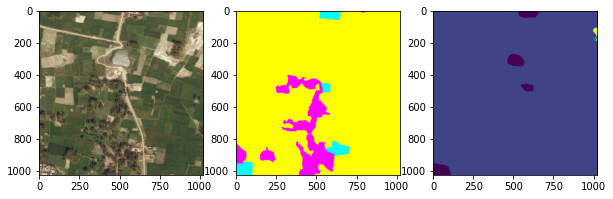

(7, 1024, 1024)
Precision: 0.14285714285714096, Recall: 1.0217533111571293, F1: 0.2506670718955931


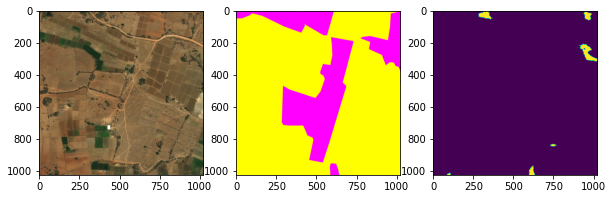

(7, 1024, 1024)
Precision: 0.1428571428571409, Recall: 0.9999999999999047, F1: 0.24999997812499597


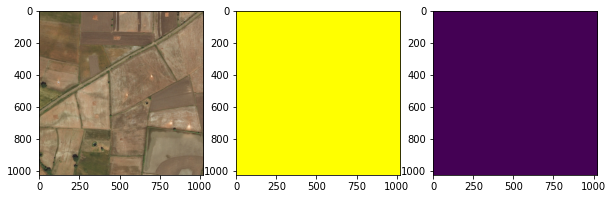

(7, 1024, 1024)
Precision: 0.14285714285713733, Recall: 0.35221385955807194, F1: 0.20326884524539116


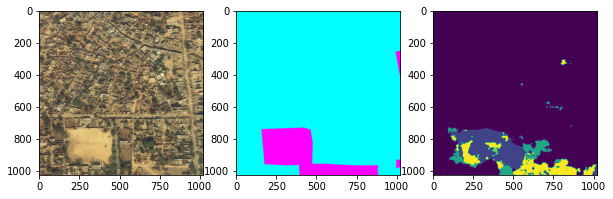

(7, 1024, 1024)
Precision: 0.14285714285713708, Recall: 0.3370828628539718, F1: 0.20066960072892273


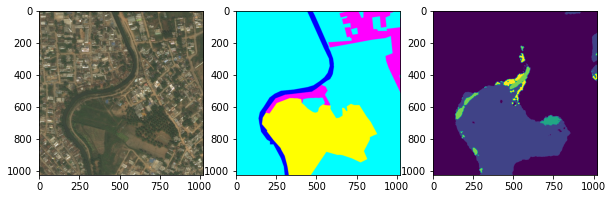

(7, 1024, 1024)
Precision: 0.14285714285714107, Recall: 1.094196319579974, F1: 0.2527194693688786


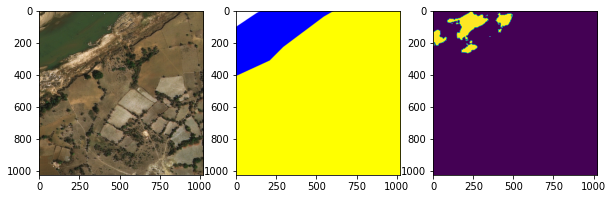

(7, 1024, 1024)
Precision: 0.14285714285714088, Recall: 0.9824600219725627, F1: 0.24944331007238887


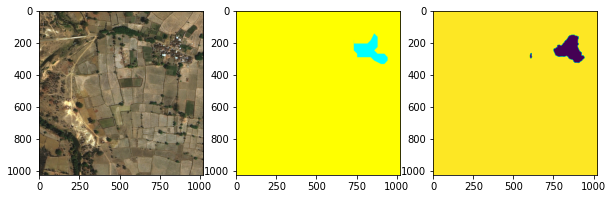

(7, 1024, 1024)
Precision: 0.1428571428571409, Recall: 0.9953002929686552, F1: 0.24985250576092483


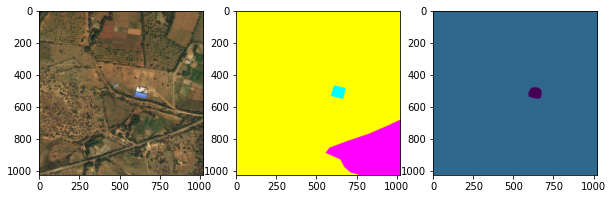

(7, 1024, 1024)
Precision: 0.1428571428571407, Recall: 0.9066009521483511, F1: 0.2468214977058691


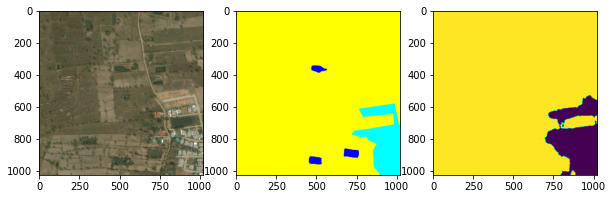

(7, 1024, 1024)
Precision: 0.14285714285714085, Recall: 0.9704599380492239, F1: 0.24905235701862408


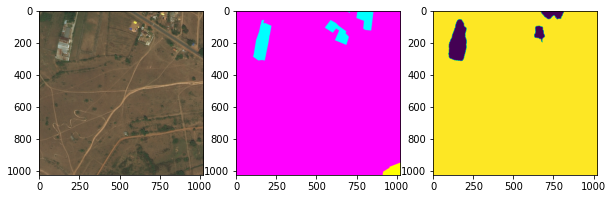

(7, 1024, 1024)
Precision: 0.14285714285714216, Recall: 2.7394332885739576, F1: 0.2715532028335192


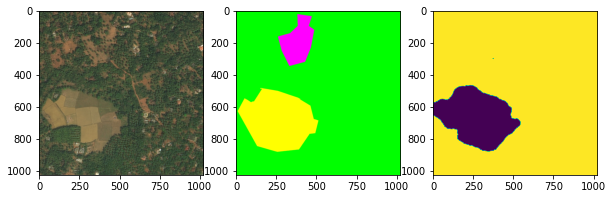

(7, 1024, 1024)
Precision: 0.1428571428571409, Recall: 0.9999999999999047, F1: 0.24999997812499597


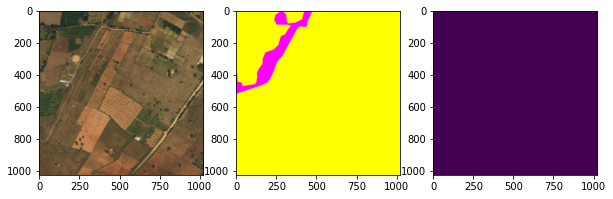

(7, 1024, 1024)
Precision: 0.14285714285714093, Recall: 1.0144729614256847, F1: 0.2504466024282202


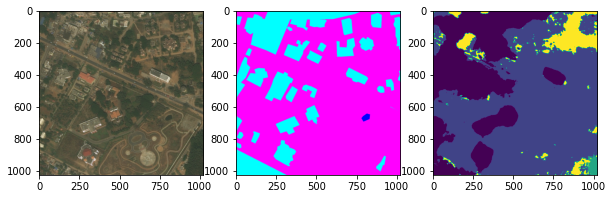

(7, 1024, 1024)
Precision: 0.14285714285714246, Recall: 4.910429000854024, F1: 0.27763709532103603


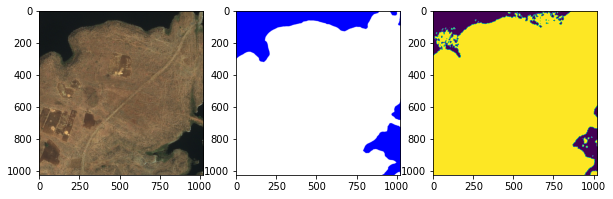

(7, 1024, 1024)
Precision: 0.1428571428571409, Recall: 0.9916706085204133, F1: 0.24973777350042992


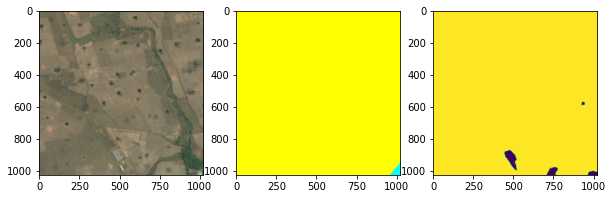

(7, 1024, 1024)
Precision: 0.1428571428571407, Recall: 0.9068031311034292, F1: 0.24682898898917813


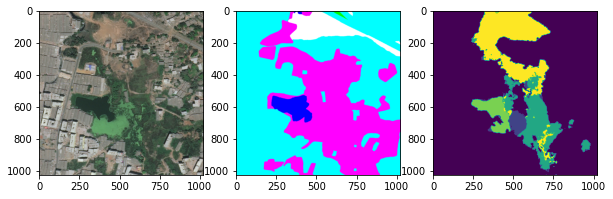

(7, 1024, 1024)
Precision: 0.1428571428571408, Recall: 0.9358224868773523, F1: 0.24787510696927428


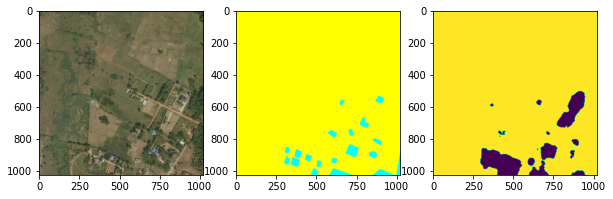

(7, 1024, 1024)
Precision: 0.14285714285714085, Recall: 0.970509529113677, F1: 0.24905398999718487


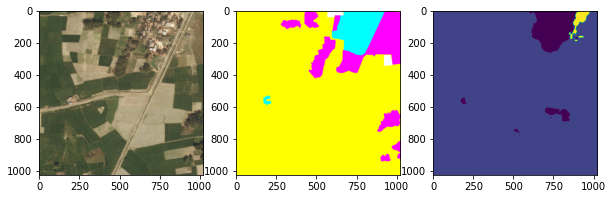

(7, 1024, 1024)
Precision: 0.1428571428571409, Recall: 0.9949092864989286, F1: 0.24984018145043066


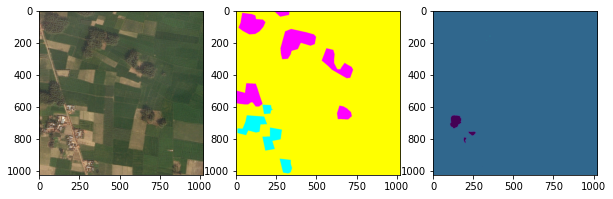

(7, 1024, 1024)
Precision: 0.14285714285714243, Recall: 4.592528343200246, F1: 0.27709484926918987


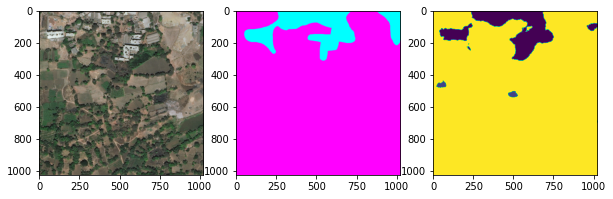

(7, 1024, 1024)
Precision: 0.14285714285714088, Recall: 0.9823179244994181, F1: 0.24943872943984674


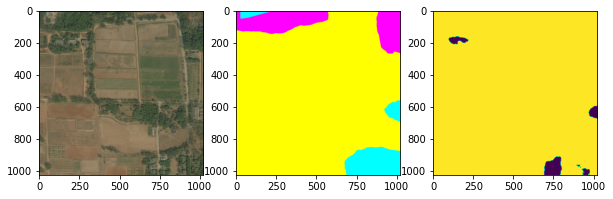

(7, 1024, 1024)
Precision: 0.14285714285714243, Recall: 4.481971740722229, F1: 0.27688880151866146


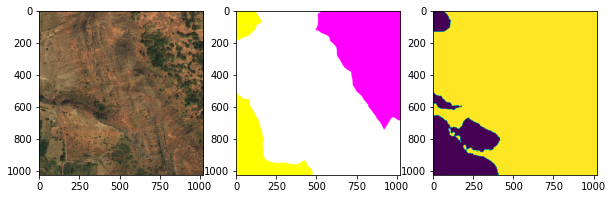

(7, 1024, 1024)
Precision: 0.14285714285714016, Recall: 0.7166423797606739, F1: 0.23822577725196922


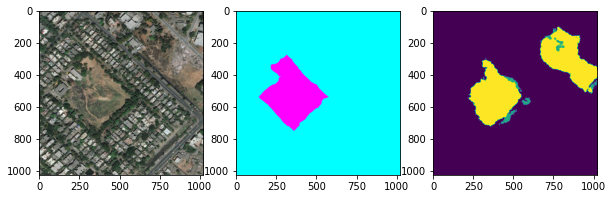

(7, 1024, 1024)
Precision: 0.1428571428571409, Recall: 0.9976987838744167, F1: 0.24992791998965763


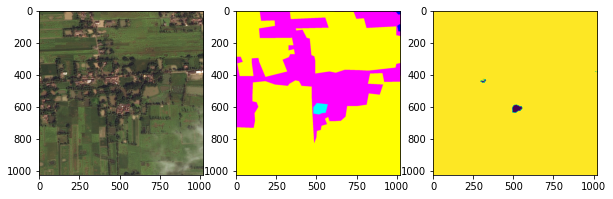

(7, 1024, 1024)
Precision: 0.14285714285714202, Recall: 2.3197383880613023, F1: 0.2691397597996021


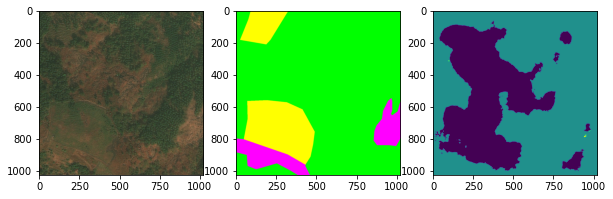

(7, 1024, 1024)
Precision: 0.1428571428571409, Recall: 1.0001144409178735, F1: 0.2500035540474822


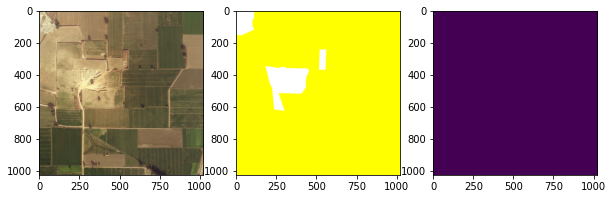

(7, 1024, 1024)
Precision: 0.1428571428571409, Recall: 0.9999999999999047, F1: 0.24999997812499597


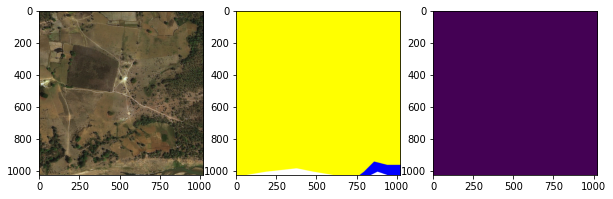

KeyboardInterrupt: ignored

In [ ]:
precision_arr = []
recall_arr = []
f1_arr = []
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    print(pred_mask.shape)
    true_pred = np.argmax(pred_mask,axis=0)
    tp = (gt_mask * true_pred).sum()
    tn = ((1 - gt_mask) * (1 - true_pred)).sum()
    fp = ((1 - gt_mask) * true_pred).sum()
    fn = (gt_mask * (1 - true_pred)).sum()

    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    f1 = 2* (precision*recall) / (precision + recall + epsilon)

    precision_arr.append(precision)
    recall_arr.append(recall)
    f1_arr.append(f1)

    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    
    print(f'Precision: {precision}, Recall: {recall}, F1: {f1}')

    
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to foreground
    # pred_urban_land_heatmap = pred_mask[:,:,select_classes.index('urban_land')]
    # pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    pred_mask = reverse_one_hot(pred_mask)
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
    # cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    # visualize(
    #     original_image = image_vis,
    #     ground_truth_mask = gt_mask,
    #     predicted_mask = pred_mask,
    #     # pred_urban_land_heatmap = pred_urban_land_heatmap
    # )
    
    # images, masks, outputs= images.cpu().detach(), masks.cpu().detach().numpy(), outputs.cpu().detach().numpy()
    # colour_codes = np.array(self.class_rgb_values)
    
    # ground_truth_array = []
    # for i in range(len(masks)):
    #     colour_mask = colour_codes[masks[i]]
    #     temp_mask = Image.fromarray(colour_mask.astype('uint8'), 'RGB')
    #     ground_truth = self.mask_transform(temp_mask)
    #     ground_truth_array.append(ground_truth)
    # ground_truths = torch.stack(ground_truth_array, 0) 

    # prediction_array = []
    # for i in range(len(outputs)):
    #     class_mask = np.argmax(outputs[i], axis=0).astype('int')
    #     colour_prediction = colour_codes[class_mask]
    #     temp_prediction = Image.fromarray(colour_prediction.astype('uint8'), 'RGB')
    #     prediction = self.mask_transform(temp_prediction)
    #     prediction_array.append(prediction)
    # predictions = torch.stack(prediction_array, 0) 
    
    # image_grid = torchvision.utils.make_grid(images)
    # ground_truth_grid = torchvision.utils.make_grid(ground_truths)
    # prediction_grid = torchvision.utils.make_grid(predictions)
    
    # image_grid = np.transpose(image_grid.numpy(), (1, 2, 0))
    # ground_truth_grid = np.transpose(ground_truth_grid.numpy(), (1, 2, 0))
    # prediction_grid = np.transpose(prediction_grid.numpy(), (1, 2, 0))
    
        
    
    
    
    


    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 5))
      
    ax1.imshow(image_vis)
    ax2.imshow(gt_mask)
    ax3.imshow(pred_mask)
    plt.show()

In [ ]:
print(np.average(precision_arr))
print(np.average(recall_arr))
print(np.average(f1_arr))


In [ ]:
# test_epoch = smp.utils.train.ValidEpoch(
#     model,
#     loss=loss, 
#     metrics=metrics, 
#     device=DEVICE,
#     verbose=True,
# )

# valid_logs = test_epoch.run(test_dataloader)
# print("Evaluation on Test Data: ")
# print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
# print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

In [ ]:
# train_logs_df = pd.DataFrame(train_logs_list)
# valid_logs_df = pd.DataFrame(valid_logs_list)
# train_logs_df.T

In [ ]:
# plt.figure(figsize=(20,8))
# plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
# plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
# plt.xlabel('Epochs', fontsize=20)
# plt.ylabel('IoU Score', fontsize=20)
# plt.title('IoU Score Plot', fontsize=20)
# plt.legend(loc='best', fontsize=16)
# plt.grid()
# plt.savefig('iou_score_plot.png')
# plt.show()

In [ ]:
# plt.figure(figsize=(20,8))
# plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
# plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
# plt.xlabel('Epochs', fontsize=20)
# plt.ylabel('Dice Loss', fontsize=20)
# plt.title('Dice Loss Plot', fontsize=20)
# plt.legend(loc='best', fontsize=16)
# plt.grid()
# plt.savefig('dice_loss_plot.png')
# plt.show()